# Load covidtracking data and make some plots

- 4/6 todo
  - set arrow location automatically (xmax)
  
- 4/5 todo
  - [X] hannah refactored code, I adapted with recent updates
  - [X] run code tonight
  - [ ] fix death inset not being annotated
  

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser
from argparse import Namespace

sns.set_style('whitegrid')

from src import covid_cases as cvd

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

## covidtracking.com data

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
data = r.json()
ctDf = pd.DataFrame(data)

# save current data
datestr = datetime.datetime.now().strftime('%y%m%d')
ctDf.to_hdf('./ct-data/covidtracking-data-%s.h5'%datestr, key='ct', complevel=9, complib='zlib')

In [3]:
paramsC = pd.DataFrame(index={'DC','MD','VA','NY'}, columns=['fullname'])
paramsC.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
paramsC.loc[:,'labYOff'] = pd.Series({ 'DC': -15, 'MD': +10, 'VA': -10, 'NY':-15})
paramsC.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': +5, 'NY': 0})
paramsC.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NY': 0.8})
#params.loc[:,'xoff'] = pd.Series({ 'DC': -9, 'MD': -6, 'VA': -6, 'NY': -0.3})
paramsC.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NY': -1})
paramsC.loc[:,'color'] = pd.Series({ 'NY': 0.4, 'DC': '#1f77b4', 'MD': '#ff7f0e', 'VA': '#2ca02c'})

display(paramsC)

,fullname,labYOff,labXOff,lw,xoff,color
MD,Maryland,10,0,2.0,0,#ff7f0e
VA,Virginia,-10,5,2.0,0,#2ca02c
DC,District of Columbia,-15,0,2.0,0,#1f77b4
NY,NaN,-15,0,0.8,-1,0.4


In [4]:
#Data: http://covidtracking.com  updated Apr 04 2020, 20:00 EDTGraphic: Hannah Goldbach, Mark Histed  @hannah_goldbach @histedlab
tDStr = datetime.date.today().strftime('%b %-d 2020')
tCredStr = 'Updated %s, 20:00 EDT\n  data: http://covidtracking.com\nGraphic: Hannah Goldbach, Mark Histed\n  @hannah_goldbach @histedlab' % tDStr
print(tCredStr)

Updated Apr 9 2020, 20:00 EDT
  data: http://covidtracking.com
Graphic: Hannah Goldbach, Mark Histed
  @hannah_goldbach @histedlab


Latest data for DC: 2020-04-09 00:00:00
Latest data for MD: 2020-04-09 00:00:00
Latest data for VA: 2020-04-09 00:00:00
Latest data for NY: 2020-04-09 00:00:00
Latest data for DC: 2020-04-09 00:00:00
Latest data for MD: 2020-04-09 00:00:00
Latest data for VA: 2020-04-09 00:00:00


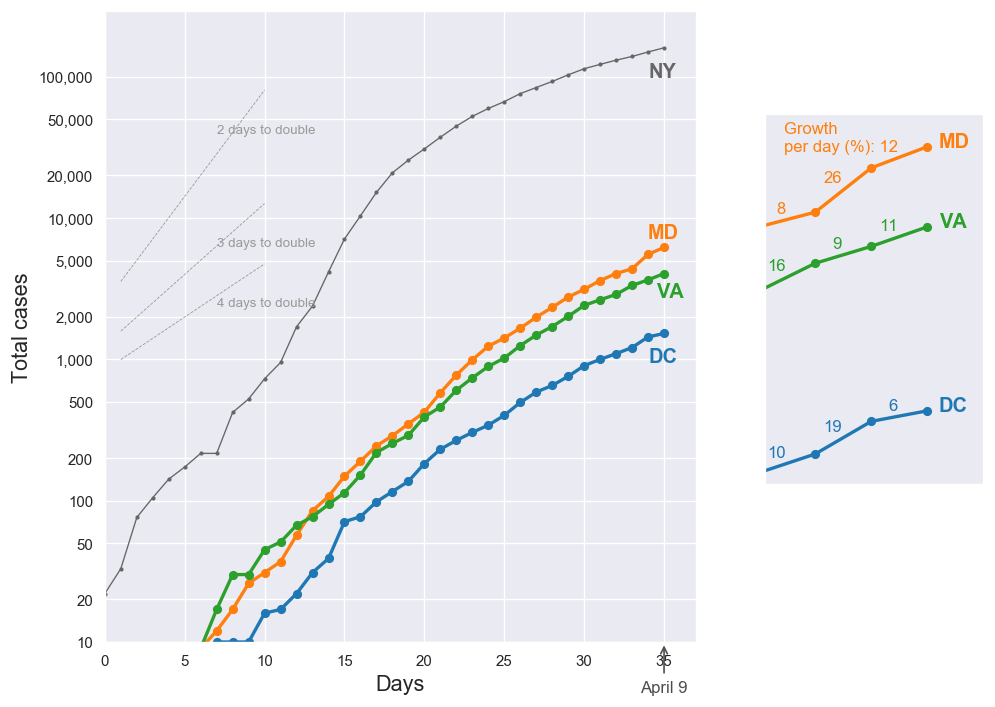

In [5]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

xlim = r_[0,37]
todayx = 0 #26

# big plot - states
df = ctDf.copy()
for st in ['DC', 'MD', 'VA', 'NY']:
    df, paramsC = cvd.plot_state(df, st, paramsC, ax, False)

# big plot fixup
cvd.fixups(ax)
#ADJUST AXIS LIMS TO FIT 
ax.set_xlim(xlim)  
ax.set_ylim([10, ax.get_ylim()[1]])
ax.set_ylabel('Total cases')

cvd.plot_guide_lines(ax)

# inset
ylim = r_[450, 3200]*2.3 #ADJUST YLIM TO FIT 
axins = cvd.inset(ctDf, paramsC, ax, ylim, is_inset=True)

#case doubling lines 
xs = r_[1,10] #ADJUST COORDS AS CASES CLIMB
dtL = [2,3,4]
cvd.case_anno_inset_double(xs, axins, paramsC) #might have to adjust in scropt 

#add arrow
tStr = datetime.date.today().strftime('%B %-d')
ax.annotate(tStr, xy=(35,10), xycoords='data', xytext=(0,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'),
            color='0.3', ha='center')

## credit string
#ax.annotate(tCredStr, xy=(0.9,0.1), xycoords='axes fraction')

# save fig 
fig.tight_layout()
fig.savefig('./fig-output/ct-%s.png'%datestr, dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 

### Same plot for deaths

In [6]:
paramsD = paramsC.copy()
#pd.DataFrame(index={'DC','MD','VA','NJ'}, columns=['fullname'])
#paramsD.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
#paramsD.loc[:,'labYOff'] = pd.Series({ 'DC': +10, 'MD': -10, 'VA': +15, 'NJ':0})
#paramsD.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': +5, 'VA': +5, 'NJ': +10})
#paramsD.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NJ': 0.8})
#paramsD.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NJ': -1})

Latest data for DC: 2020-04-09 00:00:00
Latest data for MD: 2020-04-09 00:00:00
Latest data for VA: 2020-04-09 00:00:00
Latest data for NY: 2020-04-09 00:00:00


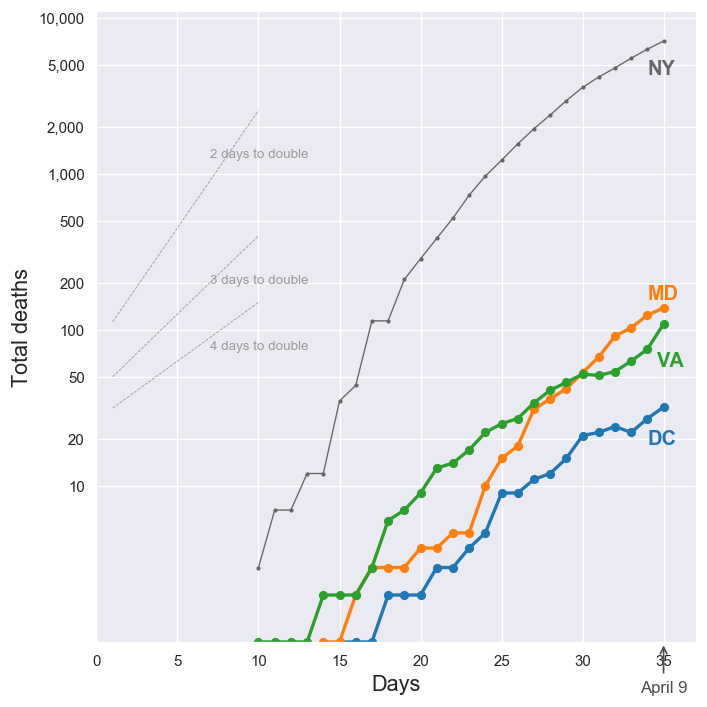

In [7]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

xlim = r_[0,37]

todayx = 0 #26

df = ctDf.copy()
for st in ['DC', 'MD', 'VA', 'NY']:
    df, paramsD = cvd.plot_state(df, st, paramsD, ax, False, is_cases=False)

# big plot fixup
cvd.fixups(ax)
#ADJUST AXIS LIMS TO FIT 
ax.set_xlim(xlim)  
ax.set_ylim([1, ax.get_ylim()[1]])
ax.set_ylabel('Total deaths')
cvd.plot_guide_lines(ax, yoffset_mult=10**-1.5)

# inset
ylim = r_[9, 50]*1.3 #ADJUST YLIM TO FIT  - get aspect ratio right
#cvd.inset(df, paramsD, ax, ylim, is_inset=True, is_cases=False)


#Death doubling annotation
#cvd.case_anno_inset_double(xs, axins, paramsD) #might have to adjust in scropt 


#add arrow
tStr = datetime.date.today().strftime('%B %-d')
ax.annotate(tStr, xy=(35, 1), xycoords='data', xytext=(0,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'), 
            color='0.3', ha='center')

fig.tight_layout()
fig.savefig('./fig-output/dt-%s.png'%datestr, dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 

In [8]:
for state in ['DC']:
    desIx = ctDf.state == state
    stDf = ctDf.loc[desIx,:].copy()
    stDf.set_index('date', inplace=True)

    posV = stDf.loc[:,'positive'][::-1]

# Positive test rates in MD, DC, VA

36

36

36

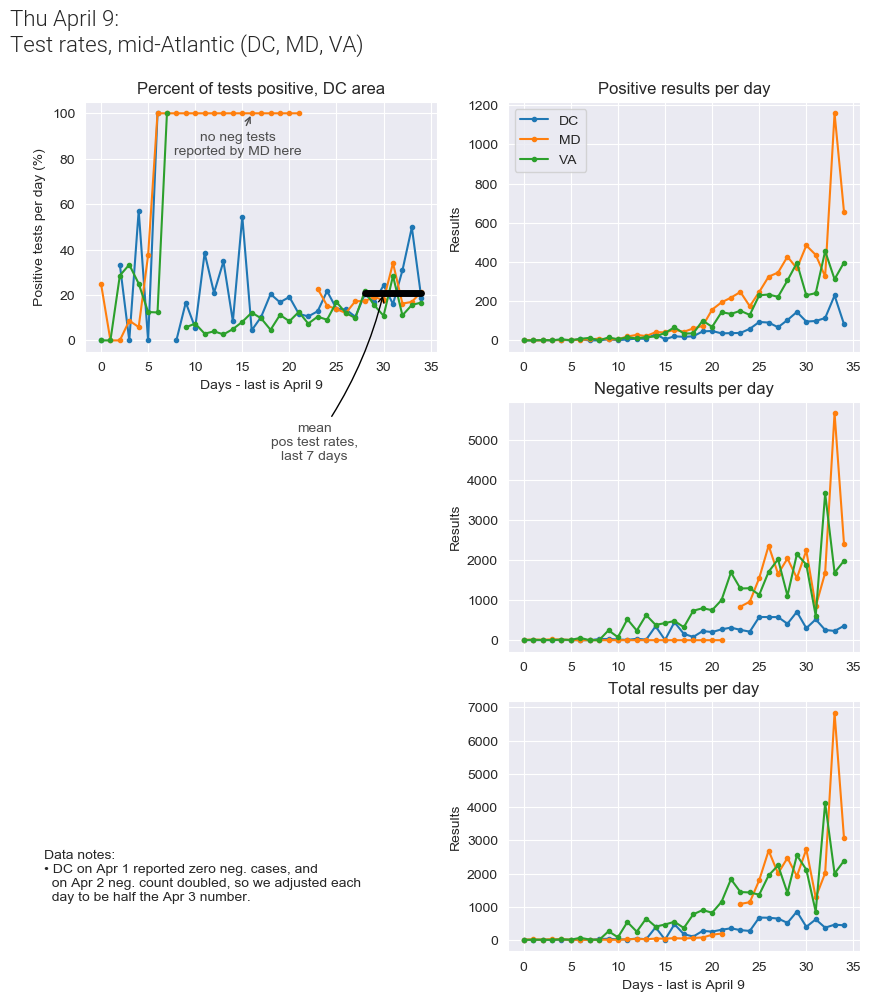

In [9]:
sns.set_style('darkgrid')

tDStr = datetime.date.today().strftime('%B %-d')
daylabel = f'Days - last is {tDStr}'

fig = plt.figure(figsize=r_[1,0.75]*[2,3]*5, dpi=100)
gs = mpl.gridspec.GridSpec(3,2)

ax = plt.subplot(gs[0,0])
datD = {}
for state in ['DC', 'MD', 'VA']:
    desIx = ctDf.state == state
    stDf = ctDf.loc[desIx,:].copy()
    stDf.set_index('date', inplace=True)

    posV = stDf.loc[:,'positive'][::-1]
    negV = stDf.loc[:,'negative'][::-1]
    pdV = np.diff(posV)
    ndV = np.diff(negV)
    # manual adjustments
    if state == 'MD':  # some errors in testing data
        ndV[22] = np.nan
    if state == 'DC':    
        ndV[26] = ndV[27]/2
        ndV[27] = ndV[27]/2
        #negV.loc[20200401] = negV.loc[20200402]/2
    pctPos = pdV/(pdV+ndV)*100        
    datD[state] = Namespace(posV=posV, negV=negV, pdV=pdV, ndV=ndV, pctPos=pctPos)
    plt.plot(pctPos, '.-', label=state)
ax.set_title('Percent of tests positive, DC area')    
#ax.legend(loc=2)
ax.set_ylabel('Positive tests per day (%)')
ax.set_xlabel(daylabel)
# markup line
maxN = len(datD['DC'].pctPos)
meanNDay = 7
desNs = r_[maxN-meanNDay:maxN]
tV = np.hstack([datD[x].pctPos[desNs] for x in datD.keys()])
tM = np.mean(tV)
plt.plot(desNs, tM+desNs*0, color='k', lw=5, ls='-', alpha=1)
# anno it
ax.annotate('mean\npos test rates,\nlast %d days'%meanNDay, 
            xy=(desNs[2],tM), xycoords='data', xytext=(-50,-120), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', color='k'), 
            color='0.3', ha='center')
ax.annotate('no neg tests\nreported by MD here', 
            xy=(16,100), xycoords='data', xytext=(-10,-30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='0.3'), 
            color='0.3', ha='center')

ax = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[2,1])
for state in ['DC', 'MD', 'VA']:
    dd = datD[state]
    display(len(dd.posV))
    pH = ax.plot(dd.pdV, '.-', label=state)        
    pH = ax2.plot(dd.ndV, '.-', label=state)            
    pH = ax3.plot(dd.ndV+dd.pdV, '.-', label=state)
ax.legend()
ax.set_title('Positive results per day')
ax.set_ylabel('Results')

ax2.set_title('Negative results per day')
ax2.set_ylabel('Results')

ax3.set_title('Total results per day')
ax3.set_ylabel('Results')
ax3.set_xlabel(daylabel)

tStr = datetime.date.today().strftime('%a %B %-d')
fig.suptitle(f'{tStr}: \n'
             'Test rates, mid-Atlantic (DC, MD, VA)',
             fontsize=16, fontname='Roboto', fontweight='light', 
             x=0.05, y=0.92, ha='left', va='bottom')

ax3.annotate('Data notes:\n'
             '• DC on Apr 1 reported zero neg. cases, and \n  on Apr 2 neg. count doubled, so we adjusted each\n  day to be half the Apr 3 number.',
              xy=(0.05,0.1), xycoords='figure fraction')

doSave = True
if doSave:
    fig.savefig('./fig-output/testing-%s.png'%datestr, 
            dpi=300, bbox_inches='tight', pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 



### Doubling time plot

In [10]:
def double_time(st, doubles):
    dD = paramsC.loc[st, 'plot_data']
    slope0 = np.diff(np.log10(dD['ys'].to_numpy()))
    double_time = -np.log10(2)/slope0
    doubles[st] = double_time
    return(doubles)

def pct_rise(st, outDf):
    dD = paramsC.loc[st, 'plot_data']
    pctsTemp = []
    for tSt in np.arange(0, len(dD['xs'])-2, 1):
        ns = r_[0:2]+tSt
        x0 = np.mean(dD['xs'][ns])
        y0 = np.mean(dD['ys'].iloc[ns])
        slope0 = np.log10(dD['ys'].iloc[ns[0]])-np.log10(dD['ys'].iloc[ns[1]])
        pct_rise = (dD['ys'].iloc[ns[0]]/dD['ys'].iloc[ns[1]] * 100) - 100
        pctsTemp.append(pct_rise)
    pcts[st] = pctsTemp
    return pcts

def find_days(df): 
    df = df.reindex(index=df.index[::-1])
    df = df.reset_index(drop = True)
    df = df.reset_index()
    df = df.rename(columns = {'index': 'day'})
    return df

In [11]:
doubles = pd.DataFrame(columns = {'DC', 'VA', 'MD'})
pcts = pd.DataFrame(columns = {'DC', 'VA', 'MD'})

for st in ['DC', 'MD', 'VA']:
    doubles = double_time(st, doubles)
    pcts = pct_rise(st, pcts)

doubles = find_days(doubles)
pcts = find_days(pcts)

dtV = paramsC.loc['DC', 'plot_data']['dtV']

In [12]:
doubles = doubles.replace([np.inf, -np.inf], np.nan)
for st in ['DC', 'MD', 'VA']:
    doubles[st].fillna((doubles[st].mean()), inplace=True)

In [13]:
import pytoolsMH as ptMH
for st in ['DC', 'MD', 'VA']:
    doubles[st+'_smooth'] = ptMH.math.smooth_lowess(doubles[st], x=None, span=7, robust=False, iter=None, axis=-1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


'plt.axvline(x = 30, alpha = 0.5)\nplt.axvline(x = 23, alpha = 0.5)\nplt.axvline(x = 16, alpha = 0.5)\nplt.axvline(x = 9, alpha = 0.5)'

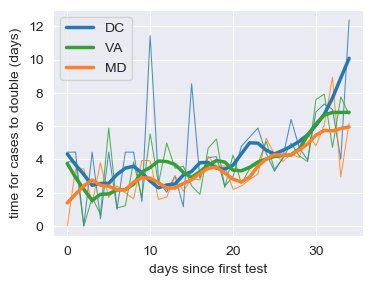

In [14]:
fig = plt.figure(figsize=r_[4, 3], dpi=100)
for st in ['DC', 'MD', 'VA']:
    plt.plot(doubles['day'], doubles[st], alpha = 0.8, lw = 0.75)
    plt.legend()
plt.plot(doubles['day'], doubles['DC_smooth'], label = 'DC', lw = 2.5, color = '#2678B2')
plt.plot(doubles['day'], doubles['VA_smooth'], label = 'VA', lw = 2.5, color = '#339F34')
plt.plot(doubles['day'], doubles['MD_smooth'], label = 'MD', lw = 2.5, color = '#FD7F28')
plt.legend()
plt.xlabel('days since first test')
plt.ylabel('time for cases to double (days)')

fig.savefig('./fig-output/doubling-%s.png'%datestr, 
            dpi=300, bbox_inches='tight', pad_inches=0.5)

"""plt.axvline(x = 30, alpha = 0.5)
plt.axvline(x = 23, alpha = 0.5)
plt.axvline(x = 16, alpha = 0.5)
plt.axvline(x = 9, alpha = 0.5)"""

## MH figure

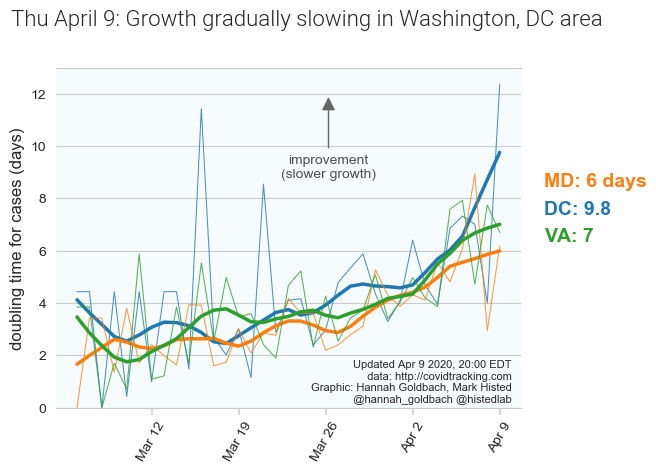

In [64]:
doSave = True

for st in ['DC', 'MD', 'VA']:
    doubles[st+'_smooth'] = ptMH.math.smooth_lowess(doubles[st], x=None, span=8, robust=False, iter=None, axis=-1)

sns.set_style('whitegrid')
fig = plt.figure(figsize=r_[4, 3]*1.5, dpi=100)
ax = plt.subplot()
ax.set_facecolor('#f6fcfd')


for (iS,st) in enumerate(['DC', 'MD', 'VA']):
    pH, = plt.plot(doubles['day'], doubles[st], alpha = 0.8, lw = 0.75)
    plt.plot(doubles['day'], doubles[st+'_smooth'], label = st, lw = 2.5, color = pH.get_color())
    last_double = doubles[st+'_smooth'].iloc[-1]
    paramsC.loc[st, 'last_double'] = last_double
    paramsC.loc[st, 'color'] = pH.get_color()

# last_double annotate    
for (iS,st) in enumerate(['MD', 'DC', 'VA']):
    last_double = paramsC.loc[st, 'last_double']
    xy = (1.05, 0.65-iS*0.08)
    tStr = f'{st}: {last_double:.2g}'
    if iS == 0:
        tStr = tStr + ' days'
    ax.annotate(tStr, xy=xy, 
                xycoords='axes fraction', color=paramsC.loc[st, 'color'], ha='left',
                fontweight='bold', fontsize=14)
    
#plt.legend()
plt.ylabel('doubling time for cases (days)', fontsize=12)

plt.grid(False, which='both', axis='x')
sns.despine(left=True, right=True, top=False, bottom=False)

x_dates = dtV.dt.strftime('%b %-d')
xt = r_[len(x_dates)-1:0:-7][::-1]
ax.set_xticks(xt-1)
ax.set_ylim([0,ax.get_ylim()[-1]])
ax.tick_params(axis='x', length=5, bottom=True, direction='out', width=0.25)
ax.set_xticklabels(x_dates[::-1].iloc[xt], rotation=60)



ax.annotate(tCredStr, fontsize=8, va='bottom', ha='right',
              xy=(0.98,0.01), xycoords='axes fraction')

tStr = datetime.date.today().strftime('%a %B %-d')
fig.suptitle('%s: Growth gradually slowing in Washington, DC area' % tStr,
             fontsize=16, fontname='Roboto', fontweight='light',
             x=0.05, y=1.01, ha='left', va='top')


ax.annotate('improvement\n(slower growth)', xy=(0.5,0.8), xycoords='figure fraction',
            textcoords='offset points', xytext=(0,-60),
            arrowprops=dict(arrowstyle='-|>,head_width=0.4,head_length=0.8', connectionstyle='arc3', color='0.4', lw=1),
            color='0.3', ha='center')


if doSave:
    fig.savefig('./fig-output/doubling-MH-%s.png'%datestr, facecolor=fig.get_facecolor(),
            dpi=300, bbox_inches='tight', pad_inches=0.5)


In [23]:
r_[10:1:-7]
len(x_dates)

36

In [26]:
r_[len(x_dates):0:-7]

array([36, 29, 22, 15,  8,  1])